In [53]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
rul_features = pd.read_csv('/rul_fsrmrmr_selected__features.csv')
X_dataset = rul_features.drop(columns=['cycle_rul'])
y_dataset = rul_features['cycle_rul']

#Generate the training and testing datasets
X_train,  X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.3, random_state=42)

In [16]:
X_train

,cycle_no,discharge_capacity,max_charge_cycle_room_temperature,cycle_soc,cycle_discharge_time,charge_capacity,average_charge_room_temperature,max_discharge_voltage,charge_capacity_drop_per_cycle,average_discharge_room_temperature,charge_cv_time,max_charge_voltage,min_discharge_voltage,max_cycle_charge_cell_temperature
103,100,3.92606,372,0.655817,4515,3.93490,323.919858,2.71390,0.00000,320.475664,-40,3.60283,2.19852,404
78,79,5.65237,383,0.942882,6030,5.65729,353.325390,3.53567,0.00186,340.460646,-5030,3.61399,2.19788,509
28,29,5.69506,435,0.951488,6135,5.70893,404.546174,3.50349,0.00876,383.543160,-7075,3.60433,2.19681,535
79,80,5.65287,373,0.941605,6075,5.64963,346.603306,3.53460,-0.00766,353.282072,-5020,3.60433,2.19681,515
5,6,5.69911,406,0.950588,6200,5.70353,378.388332,3.50027,-0.01176,372.211926,-5050,3.60648,2.19681,526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,5.65927,407,0.948153,6085,5.68892,361.098182,3.53352,0.02954,346.374384,-5050,3.60862,2.19681,511
14,15,5.70373,438,0.952270,6180,5.71362,412.008658,3.43697,0.00157,406.869846,-6455,3.60433,2.17750,531
92,93,2.64241,403,0.939258,2895,5.63555,365.785986,3.53031,-0.00653,360.545754,-8860,3.60540,1.86175,500
51,52,5.67565,329,0.946858,6115,5.68115,308.053899,3.55605,-0.01236,323.694444,-3895,3.60326,2.19574,499


In [17]:
#Convert the dataset into a Dmatrix that is optimizable for xgboost
rul_train_xgb = xgb.DMatrix(X_train, y_train, enable_categorical=True)
rul_test_xgb = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [18]:
X_train.shape

(72, 14)

In [19]:
y_train.shape

(72,)

In [47]:
#Training the model
boost_rounds = 100

model_parameters = {
    'objective':'reg:absoluteerror',
    'max_depth':3,
    'learning_rate':0.25,
    'n_estimators':100,
    'random_state':42,
    'eval_metric':'mae'
}

rul_model = xgb.train(
    params = model_parameters,
    dtrain = rul_train_xgb,
    num_boost_round = boost_rounds
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:05:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [43]:
#Predict the rul
pred_rul = rul_model.predict(rul_test_xgb)
pred_rul = pred_rul.astype(int)
accuracy = accuracy_score(y_test, pred_rul)
print("The accuracy of the model is:", (accuracy * 100.0))

The accuracy of the model is: 21.875


In [46]:
#Hyper paramater tuning the xgboost due to the poor performance recorded above
hyper_param = {
    'n_estimators':[100,150,200, 300],
    'max_depth': [3,6,9,12,15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3,0.35, 0.40, 0.45,0.50]
}

rul_grid_search = GridSearchCV(
    estimator = xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid = hyper_param,
    scoring = 'neg_mean_squared_error',
    cv=5,
    verbose = 2
)

rul_grid_search.fit(X_train, y_train)
print(rul_grid_search.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n

In [55]:
best_parameters = rul_grid_search.best_params_
best_parameters

rul_final_model = xgb.XGBRegressor(**best_parameters, objective='reg:squarederror')
rul_final_model.fit(X_train, y_train)

# Final predictions
y_pred_rul = rul_final_model.predict(X_test)

# Final RMSE
final_rmse = mean_squared_error(y_test, y_pred_rul)
print(f'Final MSE: {final_rmse:.2f}')


# Final RMSE
final_mae = mean_absolute_error(y_test, y_pred_rul)
print(f'Final MAE: {final_mae:.2f}')

Final MSE: 3.54
Final MAE: 1.59


In [56]:
y_test

,cycle_rul
30,2769
65,2734
64,2735
53,2746
45,2754
93,2706
91,2708
47,2752
10,2789
0,2799


In [57]:
y_pred_final

array([2770.3835, 2735.278 , 2735.0557, 2746.5435, 2755.731 , 2707.7056,
       2708.7278, 2752.878 , 2791.0962, 2795.3303, 2782.5435, 2770.106 ,
       2712.3076, 2705.734 , 2725.813 , 2795.9414, 2721.069 , 2766.614 ,
       2791.37  , 2774.1646, 2702.1704, 2744.824 , 2778.6602, 2725.8645,
       2755.7693, 2727.3376, 2784.919 , 2757.9998, 2759.854 , 2790.8909,
       2715.8162, 2791.039 ], dtype=float32)

Text(0.5, 1.0, 'True vs Predicted RUL')

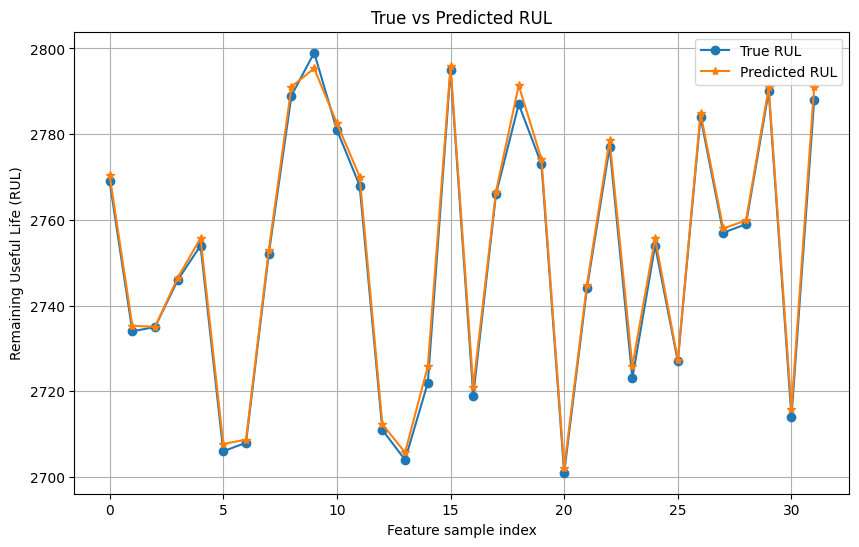

In [60]:
# Plot the true and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True RUL', marker='o')
plt.plot(y_pred_rul, label='Predicted RUL', marker='*')

# Add labels and a legend
plt.xlabel('Feature sample index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.grid()
plt.title('True vs Predicted RUL')